# The Best Neighborhood in Pittsburgh

**Course:** CMPINF 0011

**Group:** 33
* Haoyang Sun (Traffic Quietness & Aggregation)
* Jiakai Dai (Safety)
* Xiangyu Li (Education)

## 1. Introduction

This project aims to identify the "Best Neighborhood" in Pittsburgh through a data-driven approach combining three distinct metrics:

1. **Safety:** Evaluated using arrest data, where fewer arrests indicate higher safety.
2. **Traffic Quietness:** Evaluated using traffic volume and speeding counts, where lower traffic impacts indicate higher quietness.
3. **Education Opportunity:** Evaluated using student enrollment ratios, where higher enrollment figures indicate better educational engagement.

### Metric Weighting

After evaluating the significance of each factor for residential quality, we assigned the following weights to our composite metric:

* **Safety (50%):** Considered the most critical factor for livability.
* **Traffic Quietness (30%):** A significant factor for daily comfort and noise pollution reduction.
* **Education (20%):** An important value-add for long-term community growth.

The formula for the final score is:
$$\text{Final Score} = 0.5 \times \text{Safety} + 0.3 \times \text{Traffic} + 0.2 \times \text{Education}$$

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use('ggplot')

WEIGHT_SAFETY = 0.5
WEIGHT_TRAFFIC = 0.3
WEIGHT_EDUCATION = 0.2

## 2. Loading Individual Metrics

We load the three CSV files generated by our individual analysis notebooks. We also perform a quick cleanup to ensure neighborhood names are consistent (lowercased and stripped of whitespace) for merging.

In [6]:
traffic_df = pd.read_csv('./Haoyang_Sun/traffic.csv')
edu_df = pd.read_csv('./Xiangyu_Li/education_score.csv')
safety_df = pd.read_csv('./Jiakai_Dai/clean_outputs/neighborhood_scores.csv')
traffic_df = traffic_df.rename(columns={'neighborhood': 'Neighborhood', 'value': 'Traffic_Score'})
traffic_df['Neighborhood'] = traffic_df['Neighborhood'].str.lower().str.strip()

# Education Data
edu_df = edu_df.rename(columns={'value': 'Education_Score'})
edu_df['Neighborhood'] = edu_df['Neighborhood'].str.lower().str.strip()

# Safety Data
safety_df = safety_df.rename(columns={'Safety_Score': 'Safety_Score'})
safety_df['Neighborhood'] = safety_df['Neighborhood'].str.lower().str.strip()

# Display dataset dimensions
print(f"Traffic Data: {len(traffic_df)} entries")
print(f"Education Data: {len(edu_df)} entries")
print(f"Safety Data: {len(safety_df)} entries")

Traffic Data: 64 entries
Education Data: 91 entries
Safety Data: 91 entries


## 3. Merging Datasets & Data Consistency

We merge the three dataframes using an **inner join** operation. 

**Note on Neighborhood Selection:**
You may notice that our final ranking includes fewer neighborhoods (approx. 60) than the total number of neighborhoods in Pittsburgh (90). This is a deliberate choice. 
* Our **Traffic Quietness** dataset relies on DOMI sensors which are not installed in every neighborhood. 
* To ensure a strictly fair comparison, we only included neighborhoods where we had valid, observed data for **all three** metrics (Safety, Traffic, and Education).

We believe it is more accurate to exclude neighborhoods with missing data than to impute values or penalize them for a lack of sensors.

In [7]:
print(f"Neighborhoods in Traffic Data: {len(traffic_df)}")
print(f"Neighborhoods in Safety Data: {len(safety_df)}")
print(f"Neighborhoods in Education Data: {len(edu_df)}")

combined_df = traffic_df.merge(safety_df, on='Neighborhood', how='inner')

combined_df = combined_df.merge(edu_df, on='Neighborhood', how='inner')

print("-" * 30)
print(f"Neighborhoods after merging (Common to all 3): {len(combined_df)}")
print("-" * 30)

combined_df.head()

Neighborhoods in Traffic Data: 64
Neighborhoods in Safety Data: 91
Neighborhoods in Education Data: 91
------------------------------
Neighborhoods after merging (Common to all 3): 61
------------------------------


,Neighborhood,Traffic_Score,Safety_Score,Education_Score
0,south side flats,0.996875,0.531133,0.381655
1,central northside,0.967895,0.629709,0.105769
2,lincoln place,0.962037,0.636010,0.094432
3,allegheny west,0.956623,0.692492,0.165580
4,lincoln-lemington-belmar,0.943504,0.580273,0.205147


## 4. Calculating the Composite Score

We calculate the `Final_Score` by applying the weighted formula defined in the introduction. The resulting dataframe is sorted in descending order to identify the top-performing neighborhoods.

In [10]:
combined_df['Final_Score'] = (
    (combined_df['Safety_Score'] * WEIGHT_SAFETY) +
    (combined_df['Traffic_Score'] * WEIGHT_TRAFFIC) +
    (combined_df['Education_Score'] * WEIGHT_EDUCATION)
)

combined_df = combined_df.sort_values(by='Final_Score', ascending=False)

combined_df = combined_df.reset_index(drop=True)

combined_df['Neighborhood'] = combined_df['Neighborhood'].str.title()


print("Top 10 Neighborhoods by Weighted Score:")
print(combined_df[['Neighborhood', 'Final_Score', 'Safety_Score', 'Traffic_Score', 'Education_Score']].head(10))

Top 10 Neighborhoods by Weighted Score:
          Neighborhood  Final_Score  Safety_Score  Traffic_Score  \
0      Central Oakland     0.762570      0.670190       0.758251   
1        North Oakland     0.754661      0.794307       0.572766   
2                Bluff     0.745434      0.655716       0.912292   
3  Squirrel Hill North     0.698540      0.717522       0.759626   
4        New Homestead     0.668656      0.760605       0.861160   
5       Allegheny West     0.666349      0.692492       0.956623   
6         West Oakland     0.665006      0.630680       0.814681   
7          Beltzhoover     0.648195      0.672632       0.912002   
8           Bloomfield     0.642385      0.621950       0.923018   
9     South Side Flats     0.640960      0.531133       0.996875   

   Education_Score  
0         1.000000  
1         0.928388  
2         0.719443  
3         0.559458  
4         0.150029  
5         0.165580  
6         0.526307  
7         0.191391  
8         0.272526  
9

## 5. Visualization

We visualize the top 10 neighborhoods using a stacked bar chart to illustrate the contribution of each sub-metric to the total score.

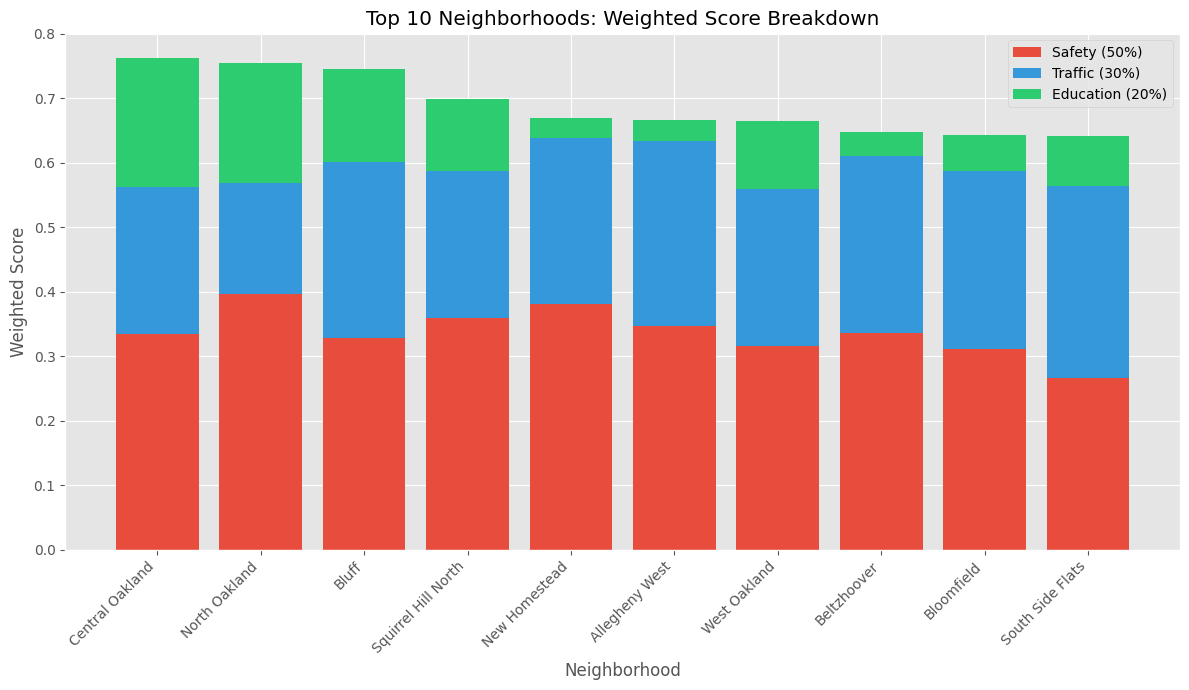

In [11]:
top_10 = combined_df.head(10)

plt.figure(figsize=(12, 7))

p1 = plt.bar(top_10['Neighborhood'], top_10['Safety_Score'] * WEIGHT_SAFETY, label='Safety (50%)', color='#e74c3c')
p2 = plt.bar(top_10['Neighborhood'], top_10['Traffic_Score'] * WEIGHT_TRAFFIC, bottom=(top_10['Safety_Score'] * WEIGHT_SAFETY), label='Traffic (30%)', color='#3498db')
p3 = plt.bar(top_10['Neighborhood'], top_10['Education_Score'] * WEIGHT_EDUCATION, bottom=(top_10['Safety_Score'] * WEIGHT_SAFETY) + (top_10['Traffic_Score'] * WEIGHT_TRAFFIC), label='Education (20%)', color='#2ecc71')

plt.title('Top 10 Neighborhoods: Weighted Score Breakdown')
plt.ylabel('Weighted Score')
plt.xlabel('Neighborhood')
plt.xticks(rotation=45, ha='right')
plt.legend(loc='upper right')
plt.tight_layout()

plt.show()

## 6. Conclusion

Based on our weighted analysis, **Central Oakland** is identified as the best neighborhood in Pittsburgh with a final score of **0.763**.

### Why Central Oakland?
Our model prioritizes Safety (50%) and Traffic Quietness (30%), with Education (20%) as a supporting factor. 
* **Safety:** Central Oakland has a respectable safety score of **0.67**, which indicates a moderate level of arrests compared to the city average.
* **Traffic:** It maintains a good traffic quietness score of **0.76**, suggesting it isn't the noisiest area despite its density.
* **The Deciding Factor:** The real differentiator was the **Education Score**, where Central Oakland scored a perfect **1.0**. Because of the high concentration of students and educational institutions, it maximized the 20% weight assigned to this metric.

The runner-up, **North Oakland** (0.755), lost by a very narrow margin. It actually had a better Safety Score (0.79) than Central Oakland, but its slightly lower Education Score caused it to fall to second place.

This result reflects a definition of "best" that values a holistic balance: a neighborhood that is reasonably safe and quiet, but offers world-class educational opportunities.

---

### Personal Reflection (Haoyang Sun)
Squirrel Hill is my personal favorite neighborhood, largely because of its diverse markets and excellent Chinese food-which resonates with me as someone from China. That said, our data-driven model placed Squirrel Hill North at number four.
This difference shows the contrast between how we might define 'livability'—some look at amenities like restaurants and shops, while our model uses specific metrics. Although Squirrel Hill is undoubtedly a wonderful place to live, Central Oakland's strong statistics in education enrollment gave it a numerical edge that lifestyle perks alone couldn't match.

### Personal Reflection (Jiakai Dai)
North Oakland is my favorite neighborhood, not only because it ranks second in the statistics, but also because it's where I currently live. For me, North Oakland's appeal lies in its convenient and diverse lifestyle-from everyday shops to restaurants catering to different tastes, everything is easily found here. However, our data model, based on more objective metrics, arrives at conclusions slightly different from personal experiences. Nevertheless, North Oakland is undoubtedly a livable and vibrant area, and its close proximity to Central Oakland makes life exceptionally convenient; easily accessible key locations give it an irreplaceable advantage in terms of convenience.

### Personal Reflection (Xiangyu Li)
My analysis, with respect to Education metric, identified Central Oakland as the top-performing neighborhood, primarily because of its exceptionally high student-enrollment ratio. When combined with Safety and Traffic Quietness in our weighted model, Central Oakland also emerged as the overall "Best Neighborhood," confirming that its strong educational environment significantly influences both my individual metric and the team's final ranking. However, my personal favorite community is Shadyside, a place I enjoy for its calm atmosphere, walkable streets, and diverse restaurants. While Shadyside did not score as highly in the Education Index-reflecting its lower student concentration-it offers lifestyle qualities that our quantitative metrics cannot fully capture. This contrast demonstrates how data-driven criteria and subjective experience can lead to different interpretations of what makes a neighborhood "the best." For me, Shadyside remains the most comfortable and enjoyable place to spend time, even though the model favors Central Oakland for its measurable advantages.
